<h1 align="center">PART III</h1>
<h1 align="center">Training and Development of Different LSTM Models</h1> 

To get started, let's download the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense
from keras.models import load_model
from keras.layers.core import Dropout

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h2 align="center">Preparation of input data</h2> 

Firstly, we will load the sample data we processed in the first part:

In [4]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [5]:
import random

pos = [doc for doc in docs if doc[1] == "pos"][:15000]
neg = [doc for doc in docs if doc[1] == "neg"][:15000]

docs = pos + neg
random.shuffle(docs)

In [6]:
print("Number of documents:", len(docs))

Number of documents: 30000


Now we will load our word2vec model. 

This may take some time, as the model contains 325 250  words, so we will get a 325 250 x 300 embedding matrix that contains all the values of the word vectors.

In [7]:
model = word2vec.KeyedVectors.load_word2vec_format('ubercorpus.lowercased.lemmatized.word2vec.300d.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [8]:
words = list(model.index_to_key)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [9]:
print("Total words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

Total words: 325250 

Word-Vectors shape: (325250, 300)


The shape of our sample for training will be `(H, 300, N)`, where:
* `H` - number of samples;
* `300` - dimension of each word; 
* `N` - number of words in each sentence.

Let's analyze how many words are usually found in the reviews:

In [10]:
max_word, min_word = 0, 100
word50, word100, word200, word300, word400  = 0, 0, 0, 0, 0
reviews_len = []

for review, state in docs:
    reviews_len.append(len(review))

    if len(review) > max_word: max_word = len(review)
    if len(review) < min_word: min_word = len(review)

    if len(review) > 50: word50 += 1
    if len(review) > 100: word100 += 1
    if len(review) > 200: word200 += 1
    if len(review) > 300: word300 += 1
    if len(review) > 400: word400 += 1
    
print("Average number of words in the review:", int(sum(reviews_len)/len(reviews_len)))
print("\nMaximum review length:", max_word, "\nMinimum review length:", min_word)
print("\nReview with more than 50 words:", word50, 
      "\nReview with more than 100 words:", word100,
      "\nReview with more than 200 words:", word200, 
      "\nReview with more than 300 words:", word300,
      "\nReview with more than 400 words:", word400)

Average number of words in the review: 40

Maximum review length: 363 
Minimum review length: 1

Review with more than 50 words: 7493 
Review with more than 100 words: 2211 
Review with more than 200 words: 323 
Review with more than 300 words: 18 
Review with more than 400 words: 0


Visualize the frequency of words in the review:

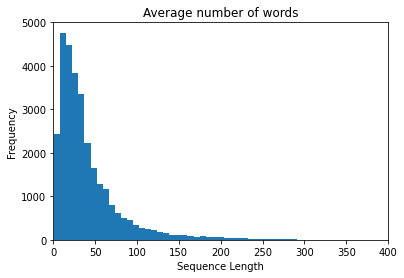

In [11]:
plt.hist(reviews_len, bins=50)
plt.axis([0, 400, 0, 5000])
plt.ylabel('Frequency')
plt.xlabel('Sequence Length');
plt.title("Average number of words");

Our next function `fix_review_len()` will do a useful job, this function is designed to fix the size of reviews to a fixed size to feed them into a neural network with reviews of a certain length. Reviews whose length is less than fixed will be extended by zeros. This process does not affect the algorithm and reviews longer than the specified length will be truncated.

In [12]:
def fix_review_len(review, length):
    if len(review) > length:
        review = review[:length]
    elif len(review) < length:
        for i in range(length - len(review)):
            zeros = [0] * 300
            review.append(zeros)
    return review

example = [3, 1, 2, 4, 5]
example = fix_review_len(example, 7)
print(example) 

[3, 1, 2, 4, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Now let's slightly improve our `sent_embed()` function from previous part and then update our dataset with word vectors.

Based on the histogram data, as well as the average number of words in the files, we can say with confidence that most reviews will have less than 100 words, which is the maximum value of the length of the sequence that we set.

In [13]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], [] 
    
    max_seq_len = 50
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence, state - state of the sentence (pos/neg)
    for sent, state in docs:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                sent_embed.append([0] * 300)
        
        # add a sentence vector to the list
        sent_embed = fix_review_len(sent_embed, max_seq_len)
        x_sent_embed.append(sent_embed)
        
        # add a label to y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    return x_sent_embed, y_sent_embed

In [14]:
x, y = sent_embed(words, docs)

In [15]:
x = np.array(x)
print("Shape of X:", x.shape)

Shape of X: (30000, 50, 300)


<h3 align="center">Split Corpus</h3>

Now, for further work, we will divide our corpus for training, testing and development sets:

In [16]:
from sklearn.model_selection import train_test_split

# train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# train dev
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [17]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

Length of x_train: 16875 | Length of y_train: 16875
Length of x_test:   7500 | Length of y_test:  7500
Length of x_val:    5625 | Length of y_val:   5625


In [18]:
print("Shape of x_train set:", x_train.shape)

Shape of x_train set: (16875, 50, 300)


<h2 align="center">LSTM Model (Stochastic Gradient Descent)</h2>

Keras's benefit is that it is built on top of symbolic mathematical libraries such as TensorFlow and Theano for fast and efficient computation. This is needed with large neural networks.

A downside of using these efficient libraries is that you must define the scope of your data upfront and for all time. Specifically, the batch size.

Neural networks are trained using the stochastic gradient descent optimization algorithm.

This involves using the current state of the model to make a prediction, comparing the prediction to the expected values, and using the difference as an estimate of the error gradient. This error gradient is then used to update the model weights and the process is repeated.

The error gradient is a statistical estimate. The more training examples used in the estimate, the more accurate this estimate will be and the more likely that the weights of the network will be adjusted in a way that will improve the performance of the model. The improved estimate of the error gradient comes at the cost of having to use the model to make many more predictions before the estimate can be calculated, and in turn, the weights updated.

Alternately, using fewer examples results in a less accurate estimate of the error gradient that is highly dependent on the specific training examples used.

This results in a noisy estimate that, in turn, results in noisy updates to the model weights, e.g. many updates with perhaps quite different estimates of the error gradient. Nevertheless, these noisy updates can result in faster learning and sometimes a more robust model.

The number of training examples used in the estimate of the error gradient is a hyperparameter for the learning algorithm called the “batch size,” or simply the “batch.”

A batch size of 32 means that 32 samples from the training dataset will be used to estimate the error gradient before the model weights are updated. One training epoch means that the learning algorithm has made one pass through the training dataset, where examples were separated into randomly selected “batch size” groups.

Historically, a training algorithm where the batch size is set to the total number of training examples is called “batch gradient descent” and a training algorithm where the batch size is set to 1 training example is called “stochastic gradient descent” or “online gradient descent.”

A configuration of the batch size anywhere in between (e.g. more than 1 example and less than the number of examples in the training dataset) is called “minibatch gradient descent.”

  - **Batch Gradient Descent**. Batch size is set to the total number of examples in the training dataset.
  - **Stochastic Gradient Descent**. Batch size is set to one.
  - **Minibatch Gradient Descent**. Batch size is set to more than one and less than the total number of examples in the training dataset. For shorthand, the algorithm is often referred to as stochastic gradient descent regardless of the batch size. Given that very large datasets are often used to train deep learning neural networks, the batch size is rarely set to the size of the training dataset.

Smaller batch sizes are used for two main reasons:

   - Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error.
   - Smaller batch sizes make it easier to fit one batch worth of training data in memory (i.e. when using a GPU). 
   - A third reason is that the batch size is often set at something small, such as 32 examples, and is not tuned by the practitioner. Small batch sizes such as 32 do work well generally.
   
Nevertheless, the batch size impacts how quickly a model learns and the stability of the learning process. It is an important hyperparameter that should be well understood and tuned by the deep learning practitioner.

<h3 align="center">Setting Up and Creating the Network</h3>

The network has one input, a hidden layer with 128 units, and an output layer with 1 unit.

A mean squared error optimization function is used for this problem with the efficient ADAM optimization algorithm.

So now let's configure and create the network:

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense

# configure network
n_neurons = 128
n_epoch = 20
n_batch = 1

# design network
model_batch = Sequential()
model_batch.add(LSTM(n_neurons, input_shape=(x.shape[1], x.shape[2])))
model_batch.add(Dense(1, activation='sigmoid'))
model_batch.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model_batch.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 219,777
Trainable params: 219,777
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_batch_hist = model_batch.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch)

Epoch 1/20
16875/16875 [==============================] - 560s 33ms/step - loss: 0.1972 - binary_accuracy: 0.6882
Epoch 2/20
16875/16875 [==============================] - 551s 33ms/step - loss: 0.1515 - binary_accuracy: 0.7828
Epoch 3/20
16875/16875 [==============================] - 544s 32ms/step - loss: 0.1356 - binary_accuracy: 0.8094
Epoch 4/20
16875/16875 [==============================] - 590s 35ms/step - loss: 0.1226 - binary_accuracy: 0.8309
Epoch 5/20
16875/16875 [==============================] - 600s 36ms/step - loss: 0.1130 - binary_accuracy: 0.8491
Epoch 6/20
16875/16875 [==============================] - 581s 34ms/step - loss: 0.1021 - binary_accuracy: 0.8636
Epoch 7/20
16875/16875 [==============================] - 565s 34ms/step - loss: 0.0946 - binary_accuracy: 0.8741
Epoch 8/20
16875/16875 [==============================] - 584s 35ms/step - loss: 0.0875 - binary_accuracy: 0.8826
Epoch 9/20
16875/16875 [==============================] - 577s 34ms/step - loss: 0.0830 

In [ ]:
score_batch = model_batch.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(score_batch[1] * 100, 2)) + '%')

5625/5625 [==============================] - 36s 6ms/step - loss: 0.1859 - binary_accuracy: 0.7673

Model Accuracy: 76.73%


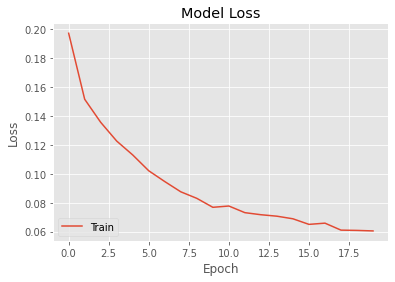

In [ ]:
plt.style.use('ggplot')
plt.plot(model_batch_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

The results are not entirely satisfactory, but let's save this model and try a different approach.

In [ ]:
from keras.models import load_model

model_batch.save('models/LSTM-Batch-Model.h5')  # save model
del model_batch  # delete existing model

In [20]:
# returns a compiled model, identical to the previous one
model_batch = load_model('models/LSTM-Batch-Model.h5')

Let's check if everything is correct:

In [ ]:
model_batch.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)

5625/5625 [==============================] - 35s 6ms/step - loss: 0.1859 - binary_accuracy: 0.7673


[0.18585748970508575, 0.767288863658905]

<h2 align="center">LSTM Model (Mini-Batch Gradient Descent)</h2>

Mini-batch gradient descent is a variation of the gradient descent algorithm that splits the training dataset into small batches that are used to calculate model error and update model coefficients.

Mini batch algorithm is the most favorable and widely used algorithm that makes precise and faster results using a batch of `m` training examples. In mini batch algorithm rather than using  the complete data set, in every iteration we use a set of `m` training examples called batch to compute the gradient of the cost function. Common mini-batch sizes range between 32 and 256.

<h3 align="center">Setting Up and Creating the Network</h3>

We will use an LSTM network fit for 20 epochs and with batch size = 128.

A mean squared error optimization function is used for this problem with the efficient ADAM optimization algorithm.

So now let's configure and create the network:

In [ ]:
# configure network
n_neurons = 128
n_epoch = 20
n_batch = 128

# design network
model_mini = Sequential()
model_mini.add(LSTM(n_neurons, input_shape=(x.shape[1], x.shape[2])))
model_mini.add(Dense(1, activation='sigmoid'))
model_mini.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model_mini.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 219,777
Trainable params: 219,777
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_mini_hist = model_mini.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch, verbose=1)

Epoch 1/20
132/132 [==============================] - 30s 211ms/step - loss: 0.1943 - binary_accuracy: 0.6979
Epoch 2/20
132/132 [==============================] - 29s 216ms/step - loss: 0.1313 - binary_accuracy: 0.8207
Epoch 3/20
132/132 [==============================] - 42s 323ms/step - loss: 0.1052 - binary_accuracy: 0.8640
Epoch 4/20
132/132 [==============================] - 37s 282ms/step - loss: 0.0825 - binary_accuracy: 0.8991
Epoch 5/20
132/132 [==============================] - 35s 268ms/step - loss: 0.0666 - binary_accuracy: 0.9215
Epoch 6/20
132/132 [==============================] - 31s 235ms/step - loss: 0.0512 - binary_accuracy: 0.9419
Epoch 7/20
132/132 [==============================] - 49s 372ms/step - loss: 0.0411 - binary_accuracy: 0.9538
Epoch 8/20
132/132 [==============================] - 32s 238ms/step - loss: 0.0364 - binary_accuracy: 0.9591
Epoch 9/20
132/132 [==============================] - 28s 209ms/step - loss: 0.0346 - binary_accuracy: 0.9630
Epoch 10/2

In [ ]:
model_mini_score = model_mini.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model_mini_score[1] * 100, 2)) + '%')

44/44 [==============================] - 4s 86ms/step - loss: 0.1847 - binary_accuracy: 0.7820

Model Accuracy: 78.2%


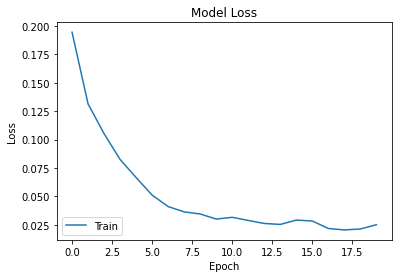

In [ ]:
plt.plot(model_mini_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

This is a good value for the model, we can use it. Let's save our model:

In [ ]:
model_mini.save('models/LSTM-Mini-Batch-Model.h5')  # save model
del model_mini  # delete existing model

In [21]:
# returns a compiled model, identical to the previous one
model_mini = load_model('models/LSTM-Mini-Batch-Model.h5')

Let's check if everything is correct:

In [ ]:
model_mini.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)

44/44 [==============================] - 4s 87ms/step - loss: 0.1847 - binary_accuracy: 0.7820


[0.18470309674739838, 0.7820444703102112]

<h2 align="center">Stacked LSTM Layers</h2>

Now we will try the model with a 3 stacked LSTM layers:

In [ ]:
# configure network
n_neurons = 100
n_epoch = 20
n_batch = 128

# design network
model3L = Sequential()

model3L.add(LSTM(n_neurons, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model3L.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model3L.add(LSTM(32))  # return a single vector of dimension 32

model3L.add(Dense(1, activation='sigmoid'))
model3L.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model3L.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           160400    
                                                                 
 lstm_1 (LSTM)               (None, 50, 32)            17024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 185,777
Trainable params: 185,777
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model3L_hist = model3L.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch, verbose=1)

Epoch 1/20
132/132 [==============================] - 35s 261ms/step - loss: 0.1186 - binary_accuracy: 0.8389
Epoch 2/20
132/132 [==============================] - 33s 250ms/step - loss: 0.0980 - binary_accuracy: 0.8724
Epoch 3/20
132/132 [==============================] - 32s 245ms/step - loss: 0.0821 - binary_accuracy: 0.8949
Epoch 4/20
132/132 [==============================] - 33s 252ms/step - loss: 0.0657 - binary_accuracy: 0.9194
Epoch 5/20
132/132 [==============================] - 33s 248ms/step - loss: 0.0516 - binary_accuracy: 0.9393
Epoch 6/20
132/132 [==============================] - 32s 245ms/step - loss: 0.0472 - binary_accuracy: 0.9443
Epoch 7/20
132/132 [==============================] - 33s 250ms/step - loss: 0.0416 - binary_accuracy: 0.9512
Epoch 8/20
132/132 [==============================] - 32s 245ms/step - loss: 0.0369 - binary_accuracy: 0.9585
Epoch 9/20
132/132 [==============================] - 32s 244ms/step - loss: 0.0358 - binary_accuracy: 0.9583
Epoch 10/2

In [ ]:
model3L_score = model3L.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(model3L_score[1] * 100, 2)) + '%')

44/44 [==============================] - 6s 97ms/step - loss: 0.1776 - binary_accuracy: 0.7925

Model Accuracy: 79.25%


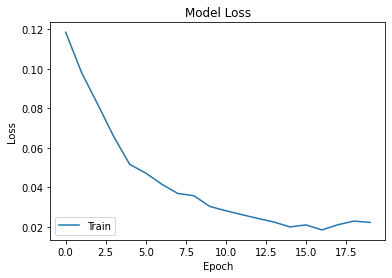

In [ ]:
plt.plot(model3L_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Let's save our model:

In [ ]:
model3L.save('models/LSTM-3L-Model.h5')  # save model
del model3L  # delete existing model

In [22]:
# returns a compiled model, identical to the previous one
model3L = load_model('models/LSTM-3L-Model.h5')

Let's check if everything is correct:

In [ ]:
model3L.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)

44/44 [==============================] - 7s 136ms/step - loss: 0.1776 - binary_accuracy: 0.7925


[0.177640900015831, 0.7925333380699158]

<h2 align="center">Bidirectional LSTM</h2>

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.

The idea of Bidirectional Recurrent Neural Networks (RNNs) is straightforward.

It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

In [ ]:
from keras.layers.core import Dropout
from keras.layers import Bidirectional

# configure network
n_epoch = 20
n_batch = 64

# design network
model_Bi_LSTM = Sequential()
model_Bi_LSTM.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(x.shape[1], x.shape[2])))
model_Bi_LSTM.add(Bidirectional(LSTM(64)))
model_Bi_LSTM.add(Dropout(0.5))
model_Bi_LSTM.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model_Bi_LSTM.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])
print(model_Bi_LSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 285,825
Trainable params: 285,825
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_Bi_LSTM_hist = model_Bi_LSTM.fit(x_train, np.asarray(y_train), epochs=n_epoch, batch_size=n_batch, verbose=1, validation_data=(x_val, np.asarray(y_val)))

Epoch 1/20
264/264 [==============================] - 72s 242ms/step - loss: 0.5121 - binary_accuracy: 0.7432 - val_loss: 0.4397 - val_binary_accuracy: 0.7984
Epoch 2/20
264/264 [==============================] - 76s 290ms/step - loss: 0.3840 - binary_accuracy: 0.8297 - val_loss: 0.4256 - val_binary_accuracy: 0.8034
Epoch 3/20
264/264 [==============================] - 63s 239ms/step - loss: 0.3016 - binary_accuracy: 0.8766 - val_loss: 0.4322 - val_binary_accuracy: 0.8107
Epoch 4/20
264/264 [==============================] - 63s 240ms/step - loss: 0.2179 - binary_accuracy: 0.9155 - val_loss: 0.4585 - val_binary_accuracy: 0.8187
Epoch 5/20
264/264 [==============================] - 64s 242ms/step - loss: 0.1425 - binary_accuracy: 0.9473 - val_loss: 0.5824 - val_binary_accuracy: 0.8069
Epoch 6/20
264/264 [==============================] - 64s 244ms/step - loss: 0.0920 - binary_accuracy: 0.9675 - val_loss: 0.6255 - val_binary_accuracy: 0.8089
Epoch 7/20
264/264 [==========================

In [ ]:
model_Bi_LSTM_score = model_Bi_LSTM.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model_Bi_LSTM_score[1] * 100, 2)) + '%')

88/88 [==============================] - 6s 72ms/step - loss: 0.9686 - binary_accuracy: 0.7993

Model Accuracy: 79.93%


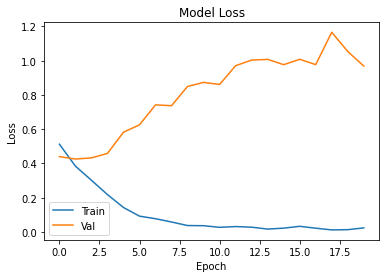

In [ ]:
plt.plot(model_Bi_LSTM_hist.history['loss'])
plt.plot(model_Bi_LSTM_hist.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')

plt.show()

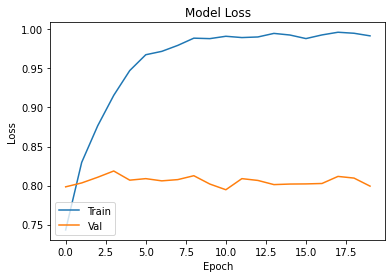

In [ ]:
plt.plot(model_Bi_LSTM_hist.history['binary_accuracy'])
plt.plot(model_Bi_LSTM_hist.history['val_binary_accuracy'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')

plt.show()

In [ ]:
model_Bi_LSTM.save('models/LSTM-Bi-Model.h5')  # save model
del model_Bi_LSTM  # delete existing model

In [23]:
# returns a compiled model, identical to the previous one
model_Bi_LSTM = load_model('models/LSTM-Bi-Model.h5')

<h2 align="center">CNN + LSTM</h2>

This approach is based entirely on [this work](https://www.aclweb.org/anthology/P16-2037.pdf). As indicated in the work:

<cite>
    
    Dimensional sentiment analysis aims to recognize continuous numerical values in multiple dimensions such as the valencearousal (VA) space. 
    
    Compared to the categorical approach that focuses on sentiment classification such as binary classification (i.e., positive and negative), the dimensional approach can provide more fine-grained sentiment analysis. This study proposes a regional CNN-LSTM model consisting of two parts: regional CNN and LSTM to predict the VA ratings of texts. 
   
    Unlike a conventional CNN which considers a whole text as input, the proposed regional CNN uses an individual sentence as a region, dividing an input text into several regions such that the useful affective information in each region can be extracted and weighted according to their contribution to the VA prediction. Such regional information is sequentially integrated across regions using LSTM for VA prediction. 

</cite>

In short, word vectors of vocabulary words are trained from a large corpus using the word2vec toolkit. For each given text, the  regional CNN model uses the sentence as a region to divide the text into R-domains, ie r1, ..., ri rj, rk, ..., rR. In each region, useful affective functions can be removed when word vectors pass sequentially through the convolutional layer and the  maxpooling  layer. Then such local (regional) features are sequentially integrated between regions using LSTM to construct a text vector for VA prediction.

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Bidirectional

# configure network
n_epoch = 20
n_batch = 64

# design network
model_CNN_LSTM = Sequential()

model_CNN_LSTM.add(Conv1D(filters=128, kernel_size=4, input_shape=(x.shape[1], x.shape[2]), padding='same', activation='relu'))
model_CNN_LSTM.add(MaxPooling1D(pool_size=3))
model_CNN_LSTM.add(Bidirectional(LSTM(64, return_sequences = True)))
model_CNN_LSTM.add(LSTM(32, recurrent_dropout = 0.4))
model_CNN_LSTM.add(Dropout(0.2))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))

model_CNN_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

print(model_CNN_LSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 50, 128)           153728    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 16, 128)          0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 16, 128)          98816     
 l)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
model_CNN_LSTM_hist = model_CNN_LSTM.fit(x_train, np.asarray(y_train), epochs=n_epoch, batch_size=n_batch, verbose=1)

Epoch 1/20
264/264 [==============================] - 34s 102ms/step - loss: 0.5486 - binary_accuracy: 0.7165
Epoch 2/20
264/264 [==============================] - 28s 105ms/step - loss: 0.4245 - binary_accuracy: 0.8054
Epoch 3/20
264/264 [==============================] - 28s 105ms/step - loss: 0.3418 - binary_accuracy: 0.8536
Epoch 4/20
264/264 [==============================] - 27s 102ms/step - loss: 0.2504 - binary_accuracy: 0.9016
Epoch 5/20
264/264 [==============================] - 27s 102ms/step - loss: 0.1758 - binary_accuracy: 0.9352
Epoch 6/20
264/264 [==============================] - 27s 102ms/step - loss: 0.1236 - binary_accuracy: 0.9575
Epoch 7/20
264/264 [==============================] - 28s 105ms/step - loss: 0.0946 - binary_accuracy: 0.9681
Epoch 8/20
264/264 [==============================] - 27s 103ms/step - loss: 0.0805 - binary_accuracy: 0.9723
Epoch 9/20
264/264 [==============================] - 27s 103ms/step - loss: 0.0592 - binary_accuracy: 0.9799
Epoch 10/2

In [ ]:
model_CNN_LSTM_score = model_CNN_LSTM.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model_CNN_LSTM_score[1] * 100, 2)) + '%')

88/88 [==============================] - 4s 36ms/step - loss: 1.0092 - binary_accuracy: 0.7858

Model Accuracy: 78.58%


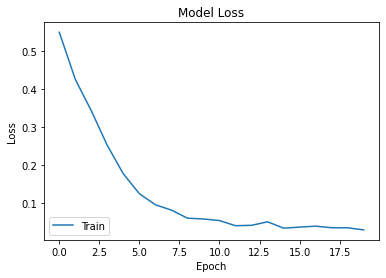

In [ ]:
plt.plot(model_CNN_LSTM_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Let's save our model:

In [ ]:
model_CNN_LSTM.save('models/LSTM-CNN-Model.h5')  # save model
del model_CNN_LSTM  # delete existing model

In [24]:
# returns a compiled model, identical to the previous one
model_CNN_LSTM = load_model('models/LSTM-CNN-Model.h5')

<h3 align="center">Testing</h3>

Let's try to check the test data with all but one of the test examples to see if the model can predict it:

In [33]:
print("Length of test data (except 1):", len(x_test[:-1]))

Length of test data (except 1): 7499


In [34]:
score_test = model_CNN_LSTM.evaluate(x_test[:-1], np.asarray(y_test[:-1]))
print(score_test)

235/235 [==============================] - 6s 21ms/step - loss: 0.4305 - binary_accuracy: 0.9059
[0.4304787218570709, 0.9058541059494019]


In [35]:
score_test_one = model_CNN_LSTM.evaluate(x_test[-1:], np.asarray(y_test[-1:]))
print(score_test_one)

1/1 [==============================] - 0s 43ms/step - loss: 0.0015 - binary_accuracy: 1.0000
[0.00153376127127558, 1.0]


In [36]:
predict_test = (model_CNN_LSTM.predict(x_test[:-1]) > 0.5).astype("int32")
print(predict_test)

[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [37]:
predict_test_one = (model_CNN_LSTM.predict(x_test[-1:]) > 0.5).astype("int32")

In [38]:
print("Predicted value:", predict_test_one[0][0], "\nActual value:", y_test[-1:][0])

Predicted value: 1 
Actual value: 1


Prediction works great, now let's visualize the data.

<h2 align="center">Visualization of Classification Report</h2>

We will need our method from previous part to visualize our data, so we will use them now.

In [27]:
def plot_classification_report(classification_report, title='Classification Report', cmap='RdBu'):
    
    lines = classification_report.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    
    for line in lines[2 : (len(lines) - 5)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [28]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False

    # add color bar
    plt.colorbar(c)

    # add text in each cell 
    show_val(c)

    # proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm_to_inch(figure_width, figure_height))

In [29]:
def show_val(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

In [30]:
def cm_to_inch(*dim):
    inch = 2.54
    return tuple(i/inch for i in dim[0]) if type(dim[0]) == tuple else tuple(i/inch for i in dim)

<h2 align="center">Comparison of Models</h2> 

A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive.

The false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives.

It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.

To make this clear:
* Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
* Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

Classification Report LSTM Stochastic Gradient Descent Model:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      3744
           1       0.89      0.83      0.86      3756

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



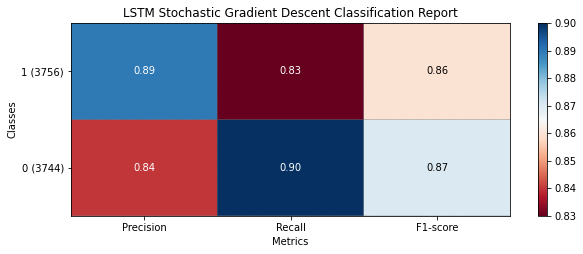

In [31]:
from sklearn.metrics import classification_report

batch_prediction = (model_batch.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Stochastic Gradient Descent Model:\n', classification_report(y_test, batch_prediction))

plot_classification_report(classification_report(y_test, batch_prediction), title='LSTM Stochastic Gradient Descent Classification Report', cmap='RdBu')

Classification Report LSTM Mini-Batch Model:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      3744
           1       0.89      0.89      0.89      3756

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



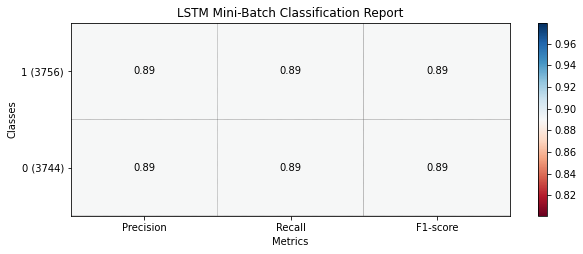

In [32]:
mini_prediction = (model_mini.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Mini-Batch Model:\n', classification_report(y_test, mini_prediction))

plot_classification_report(classification_report(y_test, mini_prediction), title='LSTM Mini-Batch Classification Report', cmap='RdBu')

Classification Report LSTM Stacked Layers Model:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      3744
           1       0.88      0.92      0.90      3756

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



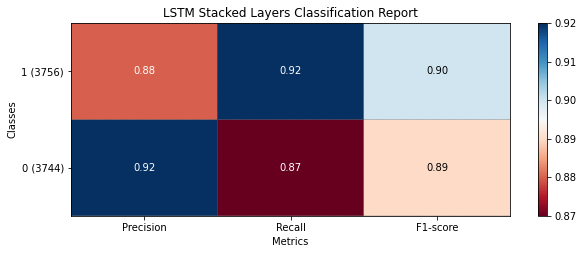

In [33]:
stack_layer_prediction = (model3L.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Stacked Layers Model:\n', classification_report(y_test, stack_layer_prediction))

plot_classification_report(classification_report(y_test, stack_layer_prediction), title='LSTM Stacked Layers Classification Report', cmap='RdBu')

Classification Report Bidirectional LSTM Model:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      3744
           1       0.89      0.93      0.91      3756

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500



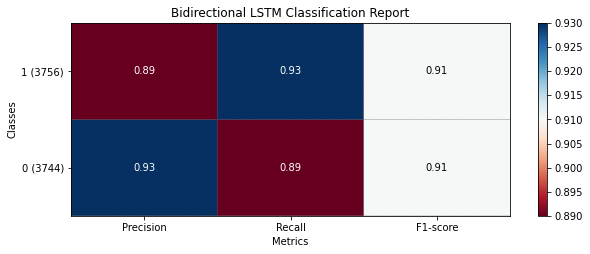

In [34]:
lstm_bi_prediction = (model_Bi_LSTM.predict(x_test) > 0.5).astype("int32")
print('Classification Report Bidirectional LSTM Model:\n', classification_report(y_test, lstm_bi_prediction))

plot_classification_report(classification_report(y_test, lstm_bi_prediction), title='Bidirectional LSTM Classification Report', cmap='RdBu')

Classification Report CNN + LSTM Model:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      3744
           1       0.90      0.91      0.91      3756

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500



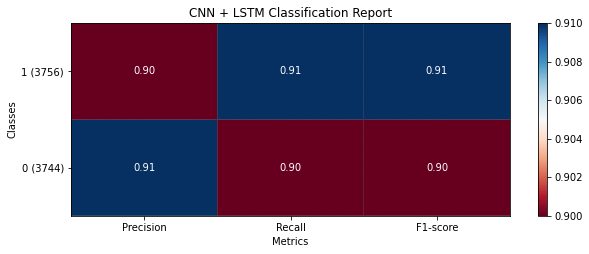

In [35]:
lstm_cnn_prediction = (model_CNN_LSTM.predict(x_test) > 0.5).astype("int32")
print('Classification Report CNN + LSTM Model:\n', classification_report(y_test, lstm_cnn_prediction))

plot_classification_report(classification_report(y_test, lstm_cnn_prediction), title='CNN + LSTM Classification Report', cmap='RdBu')

In [25]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

fprB, tprB, thresholdsB = metrics.roc_curve(y_test, model_batch.predict(x_test))
fprMB, tprMB, thresholdsMB = metrics.roc_curve(y_test, model_mini.predict(x_test))
fpr3L, tpr3L, thresholds3L = metrics.roc_curve(y_test, model3L.predict(x_test))
fprBi, tprBi, thresholdsBi = metrics.roc_curve(y_test, model_Bi_LSTM.predict(x_test))
fprCNN, tprCNN, thresholdsCNN = metrics.roc_curve(y_test, model_CNN_LSTM.predict(x_test))

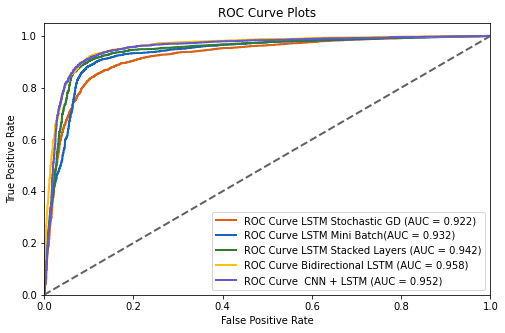

In [26]:
linewidth = 2
plt.figure(figsize=(8, 5))

plt.plot(fprB, tprB, color='#db6114', lw=linewidth, label='ROC Curve LSTM Stochastic GD (AUC = %0.3f)' % auc(fprB, tprB))
plt.plot(fprMB, tprMB, color='#1565c0', lw=linewidth, label='ROC Curve LSTM Mini Batch(AUC = %0.3f)' % auc(fprMB, tprMB))
plt.plot(fpr3L, tpr3L, color='#2e7d32', lw=linewidth, label='ROC Curve LSTM Stacked Layers (AUC = %0.3f)' % auc(fpr3L, tpr3L))
plt.plot(fprBi, tprBi, color='#ffc107', lw=linewidth, label='ROC Curve Bidirectional LSTM (AUC = %0.3f)' % auc(fprBi, tprBi))
plt.plot(fprCNN, tprCNN, color='#6557d2', lw=linewidth, label='ROC Curve  CNN + LSTM (AUC = %0.3f)' % auc(fprCNN, tprCNN))
plt.plot([0, 1], [0, 1], color='#616161', lw=linewidth, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Plots')
plt.legend(loc="lower right")

plt.show()

As we can see, all models show approximately the same result, but so far the best is the Bidirectional LSTM model (95.8%), so we gonna use it. Here we are finished, then we move on to the development of a web application.